In [1]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import random
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch.nn import functional as F
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc



In [2]:
def one_hot_encode(seq):
    """
    Given a DNA sequence, return its one-hot encoding
    """
    # Make sure seq has only allowed bases
    allowed = set("ACGUN")
    if not set(seq).issubset(allowed):
        invalid = set(seq) - allowed
        raise ValueError(f"Sequence contains chars not in allowed DNA alphabet (ACGTN): {invalid}")
        
    # Dictionary returning one-hot encoding for each nucleotide 
    nuc_d = {'A':[1.0,0.0,0.0,0.0],
             'C':[0.0,1.0,0.0,0.0],
             'G':[0.0,0.0,1.0,0.0],
             'U':[0.0,0.0,0.0,1.0],
             'N':[0.0,0.0,0.0,0.0]}
    
    # Create array from nucleotide sequence
    vec=np.array([nuc_d[x] for x in seq])
        
    return vec

In [3]:
one_hot_encode("ACGU")

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [4]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cpu')

### Загрузка датасета бинов

In [5]:
prob = pd.read_csv('20long.csv') # сразу загружается таблица бинов
prob["binary"] = prob["F3 probability"].round()

prob.binary = prob.binary.astype(int)


In [6]:
def quick_split(df, split_frac=0.8, verbose=False):
    '''
    Given a df of samples, randomly split indices between
    train and test at the desired fraction
    '''
    cols = df.columns # original columns, use to clean up reindexed cols
    df = df.reset_index()

    # shuffle indices
    idxs = list(range(df.shape[0]))
    random.shuffle(idxs)

    # split shuffled index list by split_frac
    split = int(len(idxs)*split_frac)
    train_idxs = idxs[:split]
    test_idxs = idxs[split:]
    
    # split dfs and return
    train_df = df[df.index.isin(train_idxs)]
    test_df = df[df.index.isin(test_idxs)]
        
    return train_df[cols], test_df[cols]

### Разделение на train-test

In [7]:
full_train_df, test_df = quick_split(prob)
train_df, val_df = quick_split(full_train_df)

print("Train:", train_df.shape)
print("Val:", val_df.shape)
print("Test:", test_df.shape)


Train: (7482, 10)
Val: (1871, 10)
Test: (2339, 10)


#### Примерно шестая часть записей в каждом датафрейме имеет y_true = 1

#### Создание датасета OHE - y_true

In [8]:
class SeqDatasetOHE(Dataset):
    '''
    Dataset for one-hot-encoded sequences
    '''
    def __init__(self,
                 df,
                 seq_col='seq',
                 target_col='binary'
                ):
        # +--------------------+
        # | Get the X examples |
        # +--------------------+
        # extract the DNA from the appropriate column in the df
        self.seqs = list(df[seq_col].values) # лист всех последовательностей
        self.seq_len = len(self.seqs[0])
        
        # one-hot encode sequences, then stack in a torch tensor
        self.ohe_seqs = torch.stack([torch.tensor(one_hot_encode(x)) for x in self.seqs])
        
        # +------------------+
        # | Get the Y labels |
        # +------------------+
        self.labels = torch.tensor(list(df[target_col].values)).unsqueeze(1)

        
    def __len__(self): return len(self.seqs)
    
    def __getitem__(self,idx):
        # Given an index, return a tuple of an X with it's associated Y
        # This is called inside DataLoader
        seq = self.ohe_seqs[idx]
        label = self.labels[idx]
        
        return seq, label

### Даталоадер

In [90]:
def build_dataloaders(train_df,
                      test_df,
                      seq_col='seq',
                      target_col='binary',
                      batch_size=128,
                      shuffle=True
                     ):
    '''
    Given a train and test df with some batch construction
    details, put them into custom SeqDatasetOHE() objects. 
    Give the Datasets to the DataLoaders and return.
    '''
    
    # create Datasets    
    train_ds = SeqDatasetOHE(train_df,seq_col=seq_col,target_col=target_col)
    test_ds = SeqDatasetOHE(test_df,seq_col=seq_col,target_col=target_col)

    # Put DataSets into DataLoaders
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)
    test_dl = DataLoader(test_ds, batch_size=batch_size)

    
    return train_dl,test_dl

In [91]:
train_dl, val_dl = build_dataloaders(train_df, val_df)

## Линейная модель

In [60]:
# very simple linear model
class DNA_Linear(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.seq_len = seq_len
        
        # the 4 is for our one-hot encoded vector length 4!
        self.lin1 = nn.Linear(4*seq_len,1)
        
        self.S = nn.Sigmoid()

        

    def forward(self, x):
        
        # reshape to flatten sequence dimension
        x = x.view(x.shape[0],self.seq_len*4)
        
        # Linear wraps up the weights/bias dot product operations
        x = self.lin1(x)
        
        x = self.S(x)

        
        return x
        #return out

   

## Сверточная модель

In [12]:
# basic CNN model
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=23*4,
                 kernel_size=7):
        super().__init__()
        
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            
            # 4 is for the 4 nucleotides
            nn.Conv1d(in_channels=4, out_channels = num_filters, kernel_size=kernel_size),
            
            nn.Sigmoid(),
            
            nn.Flatten(),
            
            nn.Linear(num_filters*(seq_len-kernel_size+1), 32),
            
            nn.Sigmoid(),
            
            nn.Linear(32,1),
            
            nn.Sigmoid()
        ) 
    def forward(self, x):
        
        # reshape view to batch_size x 4channel x seq_len
        # permute to put channel in correct order
        x = x.permute(0,2,1) 
        
        #print(xb.shape)
        x = self.conv_net(x)
        return x
    

### функция потерь FocalLoss

In [78]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, size_average=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = torch.Tensor([gamma])
        self.size_average = size_average
        if isinstance(alpha, (float, int)):
            if self.alpha > 1:
                raise ValueError('Not supported value, alpha should be small than 1.0')
            else:
                self.alpha = torch.Tensor([alpha, 1.0 - alpha])
        if isinstance(alpha, list): self.alpha = torch.Tensor(alpha)
        self.alpha /= torch.sum(self.alpha)
 
    def forward(self, input, target):
        #print("input: ",input)
        if input.dim() > 2:
            input = input.view(input.size(0), input.size(1), -1)  # [N,C,H,W]->[N,C,H*W] ([N,C,D,H,W]->[N,C,D*H*W])
        # target
        # [N,1,D,H,W] ->[N*D*H*W,1]
        if self.alpha.device != input.device:
            self.alpha = torch.tensor(self.alpha, device=input.device)
        target = target.view(-1, 1)
        #print("target: ",target)
        target = target.type('torch.LongTensor')
        logpt = torch.log(input + 1e-10)
        #print("target.shape: ", target.shape)
        #print("target: ", target)
        #logpt = logpt.gather(1, target)
        logpt = logpt.view(-1, 1)
        pt = torch.exp(logpt)
        alpha = self.alpha.gather(0, target.view(-1))
 
        gamma = self.gamma
 
        if not self.gamma.device == input.device:
            gamma = torch.tensor(self.gamma, device=input.device)
 
        loss = -1 * alpha * torch.pow((1 - pt), gamma) * logpt
        if self.size_average:
            loss = loss.mean()
        else:
            loss = loss.sum()
        return loss

In [79]:
# get the sequence length from the first seq in the df
seq_len = len(train_df['seq'].values[0])

# create Linear model object
model_lin = DNA_Linear(seq_len)
model_lin.to(DEVICE) # put on GPU

# run the model with default settings!
lin_train_losses, lin_val_losses = run_model(
    train_dl, 
    val_dl, 
    model_lin,
    DEVICE,
    lossf = FocalLoss()
)

  0%|          | 0/50 [00:00<?, ?it/s]

E0 | train loss: 0.000 | val loss: 0.000
E1 | train loss: 0.000 | val loss: 0.000
E2 | train loss: 0.000 | val loss: 0.000
E3 | train loss: 0.000 | val loss: 0.000
E4 | train loss: 0.000 | val loss: 0.000
E5 | train loss: 0.000 | val loss: 0.000
E6 | train loss: 0.000 | val loss: 0.000
E7 | train loss: 0.000 | val loss: 0.000
E8 | train loss: 0.000 | val loss: 0.000
E9 | train loss: 0.000 | val loss: 0.000
E10 | train loss: 0.000 | val loss: 0.000
E11 | train loss: 0.000 | val loss: 0.000
E12 | train loss: 0.000 | val loss: 0.000
E13 | train loss: 0.000 | val loss: 0.000
E14 | train loss: 0.000 | val loss: 0.000
E15 | train loss: 0.000 | val loss: 0.000
E16 | train loss: 0.000 | val loss: 0.000
E17 | train loss: 0.000 | val loss: 0.000
E18 | train loss: 0.000 | val loss: 0.000
E19 | train loss: 0.000 | val loss: 0.000
E20 | train loss: 0.000 | val loss: 0.000
E21 | train loss: 0.000 | val loss: 0.000
E22 | train loss: 0.000 | val loss: 0.000
E23 | train loss: 0.000 | val loss: 0.000
E2

In [88]:
class focal_loss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, num_classes=128, size_average=True):

        super(focal_loss, self).__init__()
        self.size_average = size_average
        if isinstance(alpha, (float, int)):    # Установить вес только первой категории
            self.alpha = torch.zeros(num_classes)
            self.alpha[0] += alpha
            self.alpha[1:] += (1 - alpha)
        if isinstance(alpha, list):  # Все веса устанавливаем самостоятельно
            self.alpha = torch.Tensor(alpha)
        self.gamma = gamma


    def forward(self, inputs, targets):
        alpha = self.alpha
        print('aaaaaaa',alpha)
        N = inputs.size(0)
        C = inputs.size(1)
        P = F.softmax(inputs,dim=1)
        print('ppppppppppppppppppppp', P)
        # ---------one hot start--------------#
        class_mask = inputs.data.new(N, C).fill_(0)  # Сгенерировать тензор той же формы, что и ввод
        print('Сделать в соответствии с формой ввода: class_mask \ n', class_mask)
        class_mask = class_mask.requires_grad_()  # Необходимо обновить, поэтому добавьте расчет градиента
        ids = targets.view(-1, 1)  # Получить индекс цели
        print('Получить индекс целей \ n', ids)
        ids = ids.type('torch.LongTensor')
        print(ids.dtype)
        #class_mask.data.scatter_(1, ids.data, 1.)  # Используйте scatter, чтобы перебросить индекс в маску
        print('Цели One_hot \ n', class_mask)  # генерация одной горячей цели
        # ---------one hot end-------------------#
        probs = (P * class_mask).sum(1).view(-1, 1)
        print('Оставить вероятность целей (часть 1), исключить часть 0 \ n', probs)
        # Формат softmax * one_hot, часть 0 удаляется, остается вероятность 1, shape = (5, 1), 5 - вероятность каждой цели

        log_p = probs.log()
        print('Получить логарифм \ n', log_p)
        # Получить логарифм
        loss = torch.pow((1 - probs), self.gamma) * log_p
        batch_loss = -alpha *loss.t()  # Соответствует следующей формуле
        print('Потеря каждой партии \ n', batch_loss)
        # batch_loss - принимать значение потерь каждой партии

        # Наконец, потери каждой партии суммируются и усредняются.
        if self.size_average:
            loss = batch_loss.mean()
        else:
            loss = batch_loss.sum()
        print('размер убытка \ n', loss)
        return loss


In [84]:
torch.manual_seed(50) # Случайное начальное значение, чтобы значение тензора было одинаковым при каждом вводе
input = torch.randn(5, 5, dtype=torch.float32, requires_grad=True)
print('входное значение \ n', input)
targets = torch.randint(5, (5, ))
print('целевое значение \ n', targets)

criterion = focal_loss()
loss = criterion(input, targets)
loss.backward()

входное значение \ n tensor([[-1.1588,  0.3673,  0.7110, -0.2373, -1.0129],
        [ 0.5580, -0.8784, -1.1446, -0.7629, -0.0170],
        [-0.0477,  0.1770, -0.6058,  0.0125,  0.6818],
        [ 0.4508,  0.4299,  1.0491,  0.0453, -1.5092],
        [-1.5502, -0.7564,  0.6274, -0.4808, -0.6856]], requires_grad=True)
целевое значение \ n tensor([1, 0, 4, 3, 4])
aaaaaaa tensor([0.2500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500])
ppppppppppppppppppppp tensor([[0.0635, 0.2920, 0.4117, 0.1595, 0.0734],
        [0.4445, 0.1057, 0.0810, 0.1186, 0.2501],
        [0.1678, 0.2101, 0.0960, 0.1782, 0.3480],
        [0.2171, 0.2126, 0.3949, 0.1447, 0.0306],
        [0.0577, 0.1277, 0.5094, 0.1682, 0.1370]], grad_fn=<SoftmaxBackward0>)
Сделать в соответствии с формой ввода: class_mask \ n tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
Получить индекс целей \ n tensor([[1],
        [0],

RuntimeError: The size of tensor a (8) must match the size of tensor b (5) at non-singleton dimension 1

In [85]:
torch.manual_seed(50) # Случайное начальное значение, чтобы значение тензора было одинаковым при каждом вводе
input = torch.tensor([[0.5443],
        [0.5562],
        [0.5329],
        [0.6318],
        [0.5101],
        [0.6368],
        [0.4974],
        [0.5835]])
print('входное значение \ n', input)
targets = torch.tensor([[0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.]])
print('целевое значение \ n', targets)

criterion = focal_loss()
loss = criterion(input, targets)
loss.backward()

входное значение \ n tensor([[0.5443],
        [0.5562],
        [0.5329],
        [0.6318],
        [0.5101],
        [0.6368],
        [0.4974],
        [0.5835]])
целевое значение \ n tensor([[0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.]])
aaaaaaa tensor([0.2500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500, 0.7500])
ppppppppppppppppppppp tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])
Сделать в соответствии с формой ввода: class_mask \ n tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])
Получить индекс целей \ n tensor([[0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.]])
torch.int64
Цели One_hot \ n tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], requires_grad=True)
Оставить вероятн

### Лосс-функция 

In [15]:
def loss_batch(model, loss_func, x, y, opt=None):
    
    logits = model(x.float())
    
    loss = loss_func(logits, y.float())
    
    if opt is not None: # Вывод для train
        
        opt.zero_grad()
        
        loss.backward()
        
        opt.step()
        
        return loss.item(), len(x)

    return loss.item(), len(x), logits # Вывод для val

### Train + Val

In [16]:
# +--------------------------------+
# | Training and fitting functions |
# +--------------------------------+

def train_step(model, train_dl, loss_func, device, opt):
    '''
    Execute 1 set of batched training within an epoch
    '''
    # Set model to Training mode
    model.train()
    
    tl = [] # train losses
    ns = [] # batch sizes, n
    
    
    # loop through train DataLoader
    for batch in train_dl:
        
        # take seq, labels
        x, y = batch
        
        # put on GPU
        x, y = x.to(device),y.to(device)
        
        # provide opt so backprop happens
        t, n = loss_batch(model, loss_func, x, y, opt=opt)
        
        # collect train loss and batch sizes
        tl.append(t)
        ns.append(n)
    
    # average the losses over all batches    
    train_loss = np.sum(np.multiply(tl, ns)) / np.sum(ns)
    
    return train_loss

In [17]:
def val_step(model, val_dl, loss_func, device):
    '''
    Execute 1 set of batched validation within an epoch
    '''
    # Set model to Evaluation mode
    model.eval()
    
    y_pred_list = []
    y_true_list = []
    
    with torch.no_grad():
        vl = [] # val losses
        ns = [] # batch sizes, n
        
        # loop through validation DataLoader
        for batch in val_dl:
            
            # take seq, labels
            x, y = batch
            
            # put on GPU
            x, y = x.to(device),y.to(device)

            # Do NOT provide opt here, so backprop does not happen
            v, n, logits = loss_batch(model, loss_func, x, y)

            # collect val loss and batch sizes
            vl.append(v)
            ns.append(n)
            
            
            y_pred = torch.argmax(logits, dim=1)
            
            
            y_pred_list.extend(y_pred.cpu().numpy())
            y_true_list.extend(y.numpy())

    # average the losses over all batches
    val_loss = np.sum(np.multiply(vl, ns)) / np.sum(ns)
    
    roc_auc = roc_auc_score(y_true = y_true_list, y_score = y_pred_list)
    
    
    return val_loss, roc_auc
    


### fit

In [18]:
def fit(epochs, model, loss_func, opt, train_dl, val_dl,device,patience=1000):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loop through epochs
    for epoch in tqdm(range(epochs)):
        
        # take a training step
        train_loss = train_step(model,train_dl,loss_func,device,opt)
        train_losses.append(train_loss)

        # take a validation step
        val_loss, acc = val_step(model,val_dl,loss_func,device)
        val_losses.append(val_loss)
        
        print(f"E{epoch} | train loss: {train_loss:.3f} | val loss: {val_loss:.3f}")

    return train_losses, val_losses




### run_model функция

In [62]:
def run_model(train_dl,val_dl,model,device,
              lr=0.01, epochs=50, 
              lossf=None,opt=torch.optim.AdamW
             ):
    '''
    Given train and val DataLoaders and a NN model, fit the mode to the training
    data. By default, use MSE loss and an SGD optimizer
    '''
    # define optimizer
    if opt:
        optimizer = opt(model.parameters(), lr=lr)
    else: # if no opt provided, just use SGD
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    # define loss function
    if lossf:
        loss_func = lossf
    else: # if no loss function provided, just use MSE
        loss_func = torch.nn.MSELoss()
    
    # run the training loop
    train_losses, val_losses = fit(
                                epochs, 
                                model, 
                                loss_func, 
                                optimizer, 
                                train_dl, 
                                val_dl, 
                                device)

    return train_losses, val_losses

### Запускаем Модель Model_lin

In [99]:
# get the sequence length from the first seq in the df
seq_len = len(train_df['seq'].values[0])

# create Linear model object
model_lin = DNA_Linear(seq_len)
model_lin.to(DEVICE) # put on GPU

# run the model with default settings!
lin_train_losses, lin_val_losses = run_model(
    train_dl, 
    val_dl, 
    model_lin,
    DEVICE,
    lossf = torch.nn.BCELoss()
)

  0%|          | 0/50 [00:00<?, ?it/s]

E0 | train loss: 0.493 | val loss: 0.478
E1 | train loss: 0.468 | val loss: 0.475
E2 | train loss: 0.467 | val loss: 0.478
E3 | train loss: 0.465 | val loss: 0.476
E4 | train loss: 0.466 | val loss: 0.477
E5 | train loss: 0.467 | val loss: 0.479
E6 | train loss: 0.467 | val loss: 0.478
E7 | train loss: 0.466 | val loss: 0.478
E8 | train loss: 0.465 | val loss: 0.476
E9 | train loss: 0.466 | val loss: 0.479
E10 | train loss: 0.467 | val loss: 0.477
E11 | train loss: 0.467 | val loss: 0.478
E12 | train loss: 0.466 | val loss: 0.480
E13 | train loss: 0.466 | val loss: 0.476
E14 | train loss: 0.466 | val loss: 0.476
E15 | train loss: 0.465 | val loss: 0.477
E16 | train loss: 0.466 | val loss: 0.477
E17 | train loss: 0.466 | val loss: 0.478
E18 | train loss: 0.466 | val loss: 0.478
E19 | train loss: 0.466 | val loss: 0.478
E20 | train loss: 0.467 | val loss: 0.480
E21 | train loss: 0.466 | val loss: 0.477
E22 | train loss: 0.466 | val loss: 0.478
E23 | train loss: 0.466 | val loss: 0.477
E2

In [100]:
def quick_loss_plot(data_label_list,loss_type="BCE Loss",sparse_n=0):
    '''
    For each train/test loss trajectory, plot loss by epoch
    '''
    for i,(train_data,test_data,label) in enumerate(data_label_list):    
        plt.plot(train_data,linestyle='--',color=f"C{i}", label=f"{label} Train")
        plt.plot(test_data,color=f"C{i}", label=f"{label} Val",linewidth=3.0)

    plt.legend()
    plt.ylabel(loss_type)
    plt.xlabel("Epoch")
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()

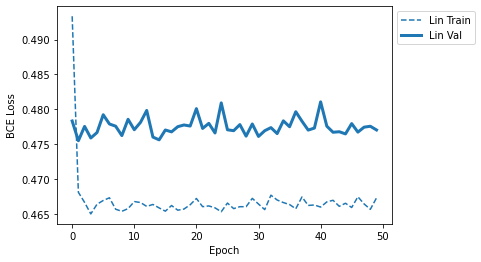

In [101]:
lin_data_label = (lin_train_losses,lin_val_losses,"Lin")
quick_loss_plot([lin_data_label])

### Запускаем Модель Model_cnn

In [102]:
seq_len = len(train_df['seq'].values[0])

# create Linear model object
model_cnn = DNA_CNN(seq_len)
model_cnn.to(DEVICE) # put on GPU

# run the model with default settings!
cnn_train_losses, cnn_val_losses = run_model(
    train_dl, 
    val_dl, 
    model_cnn,
    DEVICE,
    lossf = torch.nn.BCELoss()
)

  0%|          | 0/50 [00:00<?, ?it/s]

E0 | train loss: 0.484 | val loss: 0.485
E1 | train loss: 0.480 | val loss: 0.485
E2 | train loss: 0.481 | val loss: 0.485
E3 | train loss: 0.483 | val loss: 0.488
E4 | train loss: 0.480 | val loss: 0.485
E5 | train loss: 0.480 | val loss: 0.486
E6 | train loss: 0.480 | val loss: 0.485
E7 | train loss: 0.481 | val loss: 0.488
E8 | train loss: 0.481 | val loss: 0.486
E9 | train loss: 0.480 | val loss: 0.486
E10 | train loss: 0.480 | val loss: 0.486
E11 | train loss: 0.480 | val loss: 0.486
E12 | train loss: 0.480 | val loss: 0.486
E13 | train loss: 0.480 | val loss: 0.488
E14 | train loss: 0.480 | val loss: 0.487
E15 | train loss: 0.482 | val loss: 0.486
E16 | train loss: 0.481 | val loss: 0.485
E17 | train loss: 0.480 | val loss: 0.486
E18 | train loss: 0.481 | val loss: 0.486
E19 | train loss: 0.481 | val loss: 0.485
E20 | train loss: 0.481 | val loss: 0.485
E21 | train loss: 0.480 | val loss: 0.488
E22 | train loss: 0.481 | val loss: 0.486
E23 | train loss: 0.482 | val loss: 0.485
E2

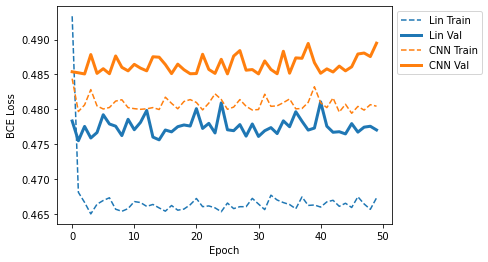

In [103]:
cnn_data_label = (cnn_train_losses,cnn_val_losses,"CNN")
quick_loss_plot([lin_data_label,cnn_data_label])

In [104]:
def quick_seq_pred(model, seqs, oracle):
    '''
    Given a model and some sequences, get the model's predictions
    for those sequences and compare to the oracle (true) output
    
    '''
    
    df = pd.DataFrame(data = {'seq': [], 'pred': [], 'actual': []})
    
    for dna in seqs:
        s = torch.tensor(one_hot_encode(dna)).unsqueeze(0).to(DEVICE)# One_Hot_Encode
        
        pred = model(s.float()) # model predicted value
        
        actual = oracle[dna] # actual value
        
        df = df.append({'seq': dna, 'pred': pred.item(), 'actual': actual}, ignore_index = True)
    return df
    

In [105]:
def graph_roc(df,model):
    y_true=df["actual"]
    y_score=df["pred"]

    fpr, tpr, treshold = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    print("roc_auc_scor: ",auc_score)
    plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC-кривая {model}')
    plt.legend(loc="lower right")
    plt.show()

### ROC_AUC на валидации linear

In [106]:
oracle = dict(val_df[['seq','binary']].values)


df1 = quick_seq_pred(model_lin, oracle.keys(), oracle)

roc_auc_scor:  0.6033503532470048


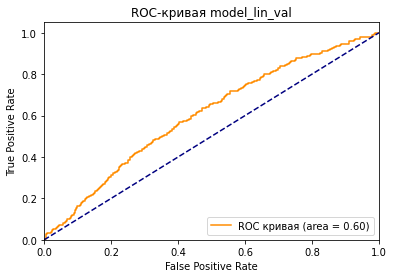

In [107]:
graph_roc(df1,"model_lin_val")

### ROC_AUC на тесте linear

In [108]:
oracle = dict(test_df[['seq','binary']].values)

df2 = quick_seq_pred(model_lin, oracle.keys(), oracle)

roc_auc_scor:  0.6186375896561317


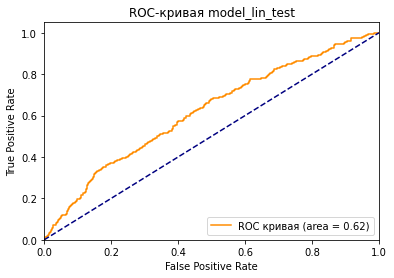

In [109]:
graph_roc(df2,"model_lin_test")

### ROC_AUC на валидации cnn

In [110]:
oracle = dict(val_df[['seq','binary']].values)

df3 = quick_seq_pred(model_cnn, oracle.keys(), oracle)

roc_auc_scor:  0.5


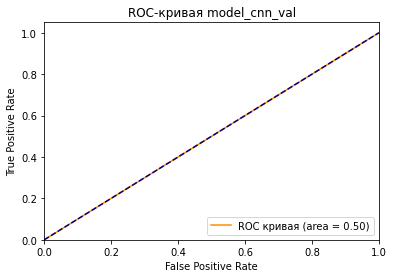

In [111]:
graph_roc(df3,"model_cnn_val")

### ROC_AUC на тесте cnn

In [112]:
oracle = dict(test_df[['seq','binary']].values)

df4 = quick_seq_pred(model_cnn, oracle.keys(), oracle)

roc_auc_scor:  0.5


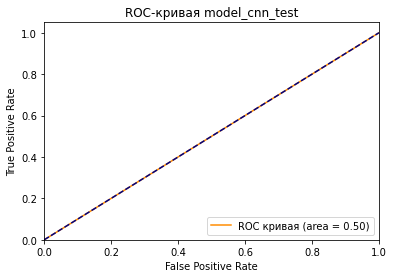

In [113]:
graph_roc(df4,"model_cnn_test")

In [114]:
df1[df1["pred"]>0.5]

,seq,pred,actual


In [115]:
df2[df2["pred"]>0.5]

,seq,pred,actual


In [116]:
df3[df3["pred"]>0.5]

,seq,pred,actual


In [117]:
df4[df4["pred"]>0.5]

,seq,pred,actual
